# Baseline Noise Detection Methods: kDN, Cleanlab, Single-Space k-NN, and Random

This notebook implements **4 baseline noise detection methods** on clinical/medical text datasets with synthetic noise injection:

1. **kDN (k-Disagreeing Neighbors)** — fraction of k-NN with different labels across 3 feature spaces (TF-IDF, sentence-transformer embeddings, combined) + average
2. **Cleanlab self-confidence** — out-of-fold predicted probability scores on TF-IDF and embedding spaces + average
3. **Single-space k-NN label consistency** — numerically equivalent to kDN (documented baseline)
4. **Random baseline** — uniform random scores

**Evaluation metrics**: ROC-AUC, Spearman rho, and Precision@k per trial, aggregated as mean +/- std across seeds.

**Feature spaces**: TF-IDF (sparse), sentence-transformer embeddings (384-dim, all-MiniLM-L6-v2), and combined (SVD-reduced TF-IDF + embeddings).

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'scipy==1.16.3', 'matplotlib==3.10.0')
    # Install CPU-only torch locally (much smaller/faster than full torch)
    _pip('torch==2.9.0+cpu', '--index-url', 'https://download.pytorch.org/whl/cpu')

# sentence-transformers — NOT on Colab, always install
_pip('sentence-transformers>=2.2.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import gc
import json
import os
import time
import warnings
from collections import Counter

# Suppress sklearn convergence warnings, spearmanr warnings, and other noisy warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="An input array is constant")
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
from scipy.stats import spearmanr
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

# Additional imports for visualization
import matplotlib.pyplot as plt

print("All imports successful.")

All imports successful.


## Data Loading

Load the mini demo dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/experiment_iter2_baseline_noise/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
datasets_raw = data["datasets"]
for ds in datasets_raw:
    print(f"Dataset '{ds['dataset']}': {len(ds['examples'])} examples")
    labels = [ex["output"] for ex in ds["examples"]]
    print(f"  Classes: {dict(Counter(labels))}")

Dataset 'mimic_iv_ed_demo': 60 examples
  Classes: {'ESI-1': 18, 'ESI-3': 20, 'ESI-2': 20, 'ESI-4': 2}


## Configuration

All tunable parameters. Adjust these to trade off runtime vs. thoroughness.

In [5]:
# --- Tunable parameters ---
# All parameters match original values. MAX_DS_SIZE is set to 60 because
# the demo dataset has exactly 60 examples (original: 3000 for large datasets).

K_NEIGHBORS = 10           # Original: 10
NOISE_RATES = [0.05, 0.10, 0.20]  # Original: [0.05, 0.10, 0.20]
N_SEEDS = 5                # Original: 5
MAX_DS_SIZE = 60           # Original: 3000 (demo dataset has 60 examples)
TFIDF_MAX_FEATURES = 5000  # Original: 5000
N_SVD_COMPONENTS = 100     # Original: 100
EMBED_BATCH_SIZE = 256     # Original: 256
CV_FOLDS_LARGE = 3         # Original: 3 (datasets > 5000)
CV_FOLDS_MEDIUM = 5        # Original: 5 (datasets > 100)
CV_FOLDS_SMALL = 3         # Original: 3 (datasets <= 100)

## Helper Functions

Core utilities for label encoding, feature space construction, KNN indexing, noise injection, and metric evaluation.

In [6]:
def encode_labels(labels: list[str]) -> tuple[np.ndarray, LabelEncoder]:
    """Integer-encode string labels."""
    le = LabelEncoder()
    y = le.fit_transform(labels)
    return y, le


def build_feature_spaces(
    texts: list[str],
    dataset_name: str,
) -> dict[str, np.ndarray]:
    """Build 3 feature spaces: TF-IDF (sparse), embedding (dense), combined (dense)."""
    print(f"[{dataset_name}] Building TF-IDF features (max_features={TFIDF_MAX_FEATURES})")
    t0 = time.time()
    vectorizer = TfidfVectorizer(
        max_features=TFIDF_MAX_FEATURES, stop_words="english", sublinear_tf=True, min_df=2
    )
    X_tfidf = vectorizer.fit_transform(texts)
    print(
        f"[{dataset_name}] TF-IDF shape: {X_tfidf.shape} ({time.time() - t0:.1f}s)"
    )

    print(f"[{dataset_name}] Computing sentence-transformer embeddings")
    t0 = time.time()
    try:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer("all-MiniLM-L6-v2")
        X_embed = model.encode(
            texts,
            batch_size=EMBED_BATCH_SIZE,
            show_progress_bar=False,
            normalize_embeddings=True,
        )
    except Exception as e:
        print(f"SentenceTransformer failed ({e}); falling back to TruncatedSVD")
        n_comp = min(300, X_tfidf.shape[1] - 1, X_tfidf.shape[0] - 1)
        n_comp = max(1, n_comp)
        svd_fallback = TruncatedSVD(n_components=n_comp)
        X_embed = svd_fallback.fit_transform(X_tfidf)
    print(
        f"[{dataset_name}] Embedding shape: {X_embed.shape} ({time.time() - t0:.1f}s)"
    )

    print(f"[{dataset_name}] Building combined feature space")
    t0 = time.time()
    n_svd_components = min(N_SVD_COMPONENTS, X_tfidf.shape[1] - 1, X_tfidf.shape[0] - 1)
    n_svd_components = max(1, n_svd_components)
    svd = TruncatedSVD(n_components=n_svd_components)
    X_tfidf_dense = svd.fit_transform(X_tfidf)
    X_combined = np.hstack([X_tfidf_dense, X_embed])
    print(
        f"[{dataset_name}] Combined shape: {X_combined.shape} ({time.time() - t0:.1f}s)"
    )

    return {"tfidf": X_tfidf, "embed": X_embed, "combined": X_combined}


def precompute_knn_indices(
    X: np.ndarray,
    k: int,
    dataset_name: str,
    space_name: str,
) -> np.ndarray:
    """Compute k-nearest-neighbor indices (excluding self). Returns (n, k) array."""
    print(f"[{dataset_name}] KNN indices for {space_name} (k={k})")
    t0 = time.time()
    actual_k = min(k, X.shape[0] - 1)
    if actual_k < 1:
        return np.zeros((X.shape[0], 0), dtype=int)
    nn = NearestNeighbors(
        n_neighbors=actual_k + 1, metric="cosine", algorithm="brute"
    )
    nn.fit(X)
    _, indices = nn.kneighbors(X)
    indices = indices[:, 1:]  # drop self-neighbor
    print(f"[{dataset_name}] KNN {space_name} done ({time.time() - t0:.1f}s)")
    return indices


def compute_kdn(knn_indices: np.ndarray, y: np.ndarray) -> np.ndarray:
    """kDN: fraction of k-NN with different labels. Higher = more likely noise."""
    if knn_indices.shape[1] == 0:
        return np.zeros(len(y))
    k = knn_indices.shape[1]
    neighbor_labels = y[knn_indices]
    disagreeing = (neighbor_labels != y[:, np.newaxis]).sum(axis=1)
    return disagreeing / k


def compute_cleanlab_scores(
    X: np.ndarray,
    y: np.ndarray,
    cv_folds: int,
    dataset_name: str,
    space_name: str,
) -> np.ndarray:
    """Compute cleanlab label-quality scores using out-of-fold predicted probs.

    Returns noise scores (higher = more likely noise), i.e. 1 - quality_score.
    """
    t0 = time.time()

    # Determine safe number of CV folds
    n_unique_classes = len(np.unique(y))
    if n_unique_classes < 2:
        return np.full(len(y), 0.5)

    class_counts = Counter(y)
    min_class_freq = min(class_counts.values())
    safe_cv = min(cv_folds, min_class_freq)
    if safe_cv < 2:
        return np.full(len(y), 0.5)

    n_samples = len(y)
    if n_samples < safe_cv * 2:
        return np.full(len(y), 0.5)

    # Manual cross-val to handle class subset issues in folds
    n_classes_total = int(y.max()) + 1
    skf = StratifiedKFold(n_splits=safe_cv, shuffle=True, random_state=42)
    pred_probs = np.full((n_samples, n_classes_total), 1e-6, dtype=np.float64)

    try:
        for train_idx, val_idx in skf.split(X, y):
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_val = X[val_idx]

            train_classes = np.unique(y_train)
            if len(train_classes) < 2:
                pred_probs[val_idx] = 1.0 / n_classes_total
                continue

            clf = SGDClassifier(
                loss="log_loss",
                max_iter=200,
                random_state=42,
            )
            clf.fit(X_train, y_train)
            fold_probs = clf.predict_proba(X_val)

            # Map fold_probs columns to global class indices
            for col_idx, cls in enumerate(clf.classes_):
                pred_probs[val_idx, cls] = fold_probs[:, col_idx]

            # Normalize rows to sum to 1
            row_sums = pred_probs[val_idx].sum(axis=1, keepdims=True)
            row_sums = np.maximum(row_sums, 1e-10)
            pred_probs[val_idx] = pred_probs[val_idx] / row_sums
    except (ValueError, IndexError) as e:
        print(
            f"[{dataset_name}] CV failed for {space_name}: {e}"
        )
        return np.full(len(y), 0.5)
    except Exception as e:
        print(
            f"[{dataset_name}] CV failed for {space_name}: {e}"
        )
        return np.full(len(y), 0.5)

    # Use self-confidence (manual, fast)
    quality_scores = pred_probs[np.arange(len(y)), y]
    noise_scores = 1.0 - quality_scores
    print(
        f"[{dataset_name}] Cleanlab {space_name} done ({time.time() - t0:.1f}s)"
    )
    return noise_scores


def inject_noise(
    y_clean: np.ndarray,
    noise_rate: float,
    seed: int,
) -> tuple[np.ndarray, np.ndarray]:
    """Uniform random label flips. Returns (y_noisy, noise_mask)."""
    rng = np.random.RandomState(seed)
    n = len(y_clean)
    unique_classes = np.unique(y_clean)
    n_classes = len(unique_classes)

    if n_classes < 2:
        return y_clean.copy(), np.zeros(n, dtype=bool)

    n_flip = int(n * noise_rate)
    if n_flip == 0:
        return y_clean.copy(), np.zeros(n, dtype=bool)

    flip_indices = rng.choice(n, size=n_flip, replace=False)
    y_noisy = y_clean.copy()
    for idx in flip_indices:
        candidates = [c for c in unique_classes if c != y_clean[idx]]
        y_noisy[idx] = rng.choice(candidates)
    noise_mask = np.zeros(n, dtype=bool)
    noise_mask[flip_indices] = True
    return y_noisy, noise_mask


def evaluate_scores(
    scores: np.ndarray, noise_mask: np.ndarray
) -> dict[str, float]:
    """Compute ROC-AUC, Spearman rho, and Precision@k."""
    y_true = noise_mask.astype(int)
    n_noisy = y_true.sum()

    # ROC-AUC
    try:
        if len(np.unique(y_true)) < 2:
            auc = float("nan")
        else:
            auc = roc_auc_score(y_true, scores)
    except ValueError:
        auc = float("nan")

    # Spearman rho
    try:
        rho, _ = spearmanr(y_true, scores)
        if np.isnan(rho):
            rho = 0.0
    except Exception:
        rho = float("nan")

    # Precision@k
    if n_noisy > 0:
        top_k_idx = np.argsort(scores)[-n_noisy:]
        prec_at_k = noise_mask[top_k_idx].mean()
    else:
        prec_at_k = float("nan")

    return {"roc_auc": auc, "spearman_rho": rho, "precision_at_k": prec_at_k}


def fmt_metrics(m: dict[str, float]) -> str:
    """Format metrics dict to compact string."""
    return (
        f"ROC-AUC={m['roc_auc']:.4f}, "
        f"rho={m['spearman_rho']:.4f}, "
        f"P@k={m['precision_at_k']:.4f}"
    )

print("Helper functions defined.")

Helper functions defined.


## Dataset Processing

For each dataset: extract texts/labels, build feature spaces (TF-IDF, embeddings, combined), precompute KNN indices, then run all noise rates x seeds. Each trial injects noise, computes all method scores, and evaluates metrics.

In [7]:
def process_dataset(
    ds_name: str,
    examples: list[dict],
    global_t0: float,
) -> dict:
    """Process a single dataset and return results dict."""
    n_examples = len(examples)
    print(f"=== Processing {ds_name} ({n_examples} examples) ===")

    # Extract texts and labels
    texts = [ex["input"] for ex in examples]
    labels = [ex["output"] for ex in examples]
    y_clean, le = encode_labels(labels)
    n_classes = len(le.classes_)
    print(f"[{ds_name}] {n_classes} classes")

    # --- Build feature spaces ONCE ---
    feature_spaces = build_feature_spaces(texts, ds_name)

    # --- Precompute KNN indices ONCE per space ---
    k_actual = min(K_NEIGHBORS, n_examples - 1)
    knn_indices = {}
    for space_name, X in feature_spaces.items():
        knn_indices[space_name] = precompute_knn_indices(
            X, k=k_actual, dataset_name=ds_name, space_name=space_name
        )

    # --- Determine CV folds based on dataset size ---
    if n_examples > 5000:
        cv_folds = CV_FOLDS_LARGE
    elif n_examples > 100:
        cv_folds = CV_FOLDS_MEDIUM
    else:
        cv_folds = CV_FOLDS_SMALL

    # --- Run trials ---
    ds_examples: list[dict] = []

    for noise_rate in NOISE_RATES:
        trial_metrics_by_method: dict[str, list[dict]] = {}

        for seed in range(N_SEEDS):
            print(f"[{ds_name}] noise={noise_rate}, seed={seed}")
            y_noisy, noise_mask = inject_noise(y_clean, noise_rate, seed)
            n_noisy = int(noise_mask.sum())

            method_scores: dict[str, np.ndarray] = {}

            # --- kDN per space ---
            kdn_per_space: dict[str, np.ndarray] = {}
            for space_name in ["tfidf", "embed", "combined"]:
                kdn_s = compute_kdn(knn_indices[space_name], y_noisy)
                kdn_per_space[space_name] = kdn_s
                method_scores[f"kdn_{space_name}"] = kdn_s

            # kDN average across 3 spaces
            method_scores["kdn_avg"] = (
                kdn_per_space["tfidf"]
                + kdn_per_space["embed"]
                + kdn_per_space["combined"]
            ) / 3.0

            # --- Cleanlab per space ---
            cl_per_space: dict[str, np.ndarray] = {}
            for space_name in ["tfidf", "embed"]:
                X = feature_spaces[space_name]
                cl_s = compute_cleanlab_scores(
                    X, y_noisy, cv_folds, ds_name, space_name
                )
                cl_per_space[space_name] = cl_s
                method_scores[f"cleanlab_{space_name}"] = cl_s

            # Cleanlab average
            method_scores["cleanlab_avg"] = (
                cl_per_space["tfidf"] + cl_per_space["embed"]
            ) / 2.0

            # --- k-NN Label Consistency (numerically == kDN, documented) ---
            for space_name in ["tfidf", "embed", "combined"]:
                method_scores[f"knn_consist_{space_name}"] = kdn_per_space[
                    space_name
                ]

            # --- Random baseline ---
            rng_random = np.random.RandomState(seed + 1000)
            method_scores["random"] = rng_random.uniform(0, 1, size=n_examples)

            # --- Evaluate all methods ---
            example_entry: dict = {
                "input": (
                    f"Trial: dataset={ds_name}, noise_rate={noise_rate}, "
                    f"seed={seed}, n_examples={n_examples}, "
                    f"n_noisy={n_noisy}, n_classes={n_classes}"
                ),
                "output": "",
                "metadata_noise_rate": noise_rate,
                "metadata_seed": seed,
                "metadata_n_noisy": n_noisy,
                "metadata_n_examples": n_examples,
                "metadata_n_classes": n_classes,
            }

            output_parts: list[str] = []
            for method_name, scores_arr in method_scores.items():
                metrics = evaluate_scores(scores_arr, noise_mask)
                predict_key = f"predict_{method_name}"
                example_entry[predict_key] = fmt_metrics(metrics)
                output_parts.append(f"{method_name}: {fmt_metrics(metrics)}")
                trial_metrics_by_method.setdefault(method_name, []).append(
                    metrics
                )

            example_entry["output"] = "; ".join(output_parts)
            ds_examples.append(example_entry)

        # --- Aggregate example for this (dataset, noise_rate) ---
        agg_entry: dict = {
            "input": (
                f"Aggregate: dataset={ds_name}, noise_rate={noise_rate}, "
                f"n_seeds={N_SEEDS}, n_examples={n_examples}, n_classes={n_classes}"
            ),
            "output": "",
            "metadata_noise_rate": noise_rate,
            "metadata_seed": "aggregate",
            "metadata_n_examples": n_examples,
            "metadata_n_classes": n_classes,
        }
        agg_parts: list[str] = []
        for method_name, metrics_list in trial_metrics_by_method.items():
            aucs = [m["roc_auc"] for m in metrics_list]
            rhos = [m["spearman_rho"] for m in metrics_list]
            pks = [m["precision_at_k"] for m in metrics_list]
            agg_str = (
                f"ROC-AUC={np.nanmean(aucs):.4f}+/-{np.nanstd(aucs):.4f}, "
                f"rho={np.nanmean(rhos):.4f}+/-{np.nanstd(rhos):.4f}, "
                f"P@k={np.nanmean(pks):.4f}+/-{np.nanstd(pks):.4f}"
            )
            agg_entry[f"predict_{method_name}"] = agg_str
            agg_parts.append(f"{method_name}: {agg_str}")
        agg_entry["output"] = "; ".join(agg_parts)
        ds_examples.append(agg_entry)

    elapsed = time.time() - global_t0
    print(
        f"[{ds_name}] Done. {len(ds_examples)} examples. Elapsed: {elapsed:.1f}s"
    )

    # Free memory
    del feature_spaces, knn_indices
    gc.collect()

    return {"dataset": ds_name, "examples": ds_examples}

print("process_dataset() defined.")

process_dataset() defined.


## Run Pipeline

Process all datasets through the baseline noise detection pipeline.

In [8]:
global_t0 = time.time()

all_dataset_results: list[dict] = []

for ds_info in datasets_raw:
    ds_name = ds_info["dataset"]
    examples = ds_info["examples"]

    if MAX_DS_SIZE > 0 and len(examples) > MAX_DS_SIZE:
        print(
            f"[{ds_name}] Subsampling from {len(examples)} to "
            f"{MAX_DS_SIZE} examples (runtime cap)"
        )
        rng = np.random.RandomState(42)
        indices = rng.choice(len(examples), size=MAX_DS_SIZE, replace=False)
        indices.sort()
        examples = [examples[i] for i in indices]

    result = process_dataset(ds_name, examples, global_t0)
    all_dataset_results.append(result)

total_examples = sum(len(ds["examples"]) for ds in all_dataset_results)
total_time = time.time() - global_t0
print(f"\nDone! {total_examples} total examples across {len(all_dataset_results)} datasets in {total_time:.1f}s")

=== Processing mimic_iv_ed_demo (60 examples) ===
[mimic_iv_ed_demo] 4 classes
[mimic_iv_ed_demo] Building TF-IDF features (max_features=5000)
[mimic_iv_ed_demo] TF-IDF shape: (60, 85) (0.0s)
[mimic_iv_ed_demo] Computing sentence-transformer embeddings


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[mimic_iv_ed_demo] Embedding shape: (60, 384) (21.5s)
[mimic_iv_ed_demo] Building combined feature space
[mimic_iv_ed_demo] Combined shape: (60, 443) (0.1s)
[mimic_iv_ed_demo] KNN indices for tfidf (k=10)
[mimic_iv_ed_demo] KNN tfidf done (0.0s)
[mimic_iv_ed_demo] KNN indices for embed (k=10)
[mimic_iv_ed_demo] KNN embed done (0.0s)
[mimic_iv_ed_demo] KNN indices for combined (k=10)
[mimic_iv_ed_demo] KNN combined done (0.1s)
[mimic_iv_ed_demo] noise=0.05, seed=0
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)


[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.05, seed=1
[mimic_iv_ed_demo] noise=0.05, seed=2
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.05, seed=3
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.05, seed=4
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.1, seed=0
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)


[mimic_iv_ed_demo] noise=0.1, seed=1
[mimic_iv_ed_demo] noise=0.1, seed=2
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.1, seed=3
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.1, seed=4
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.2, seed=0
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.2, seed=1


[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.2, seed=2
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.2, seed=3
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] noise=0.2, seed=4
[mimic_iv_ed_demo] Cleanlab tfidf done (0.0s)
[mimic_iv_ed_demo] Cleanlab embed done (0.0s)
[mimic_iv_ed_demo] Done. 18 examples. Elapsed: 22.3s



Done! 18 total examples across 1 datasets in 22.4s


## Results Visualization

Parse the results and display them as a summary table and grouped bar chart comparing methods across metrics.

Method                  ROC-AUC   Spearman rho   Precision@k
------------------------------------------------------------
kdn_tfidf                0.6914         0.2003        0.2833
kdn_embed                0.7975         0.3110        0.3556
kdn_combined             0.7552         0.2693        0.3667
kdn_avg                  0.7724         0.2842        0.3722
cleanlab_tfidf           0.6633         0.1734        0.2222
cleanlab_embed           0.7005         0.2128        0.2111
cleanlab_avg             0.7206         0.2336        0.2611
random                   0.4470        -0.0570        0.0500


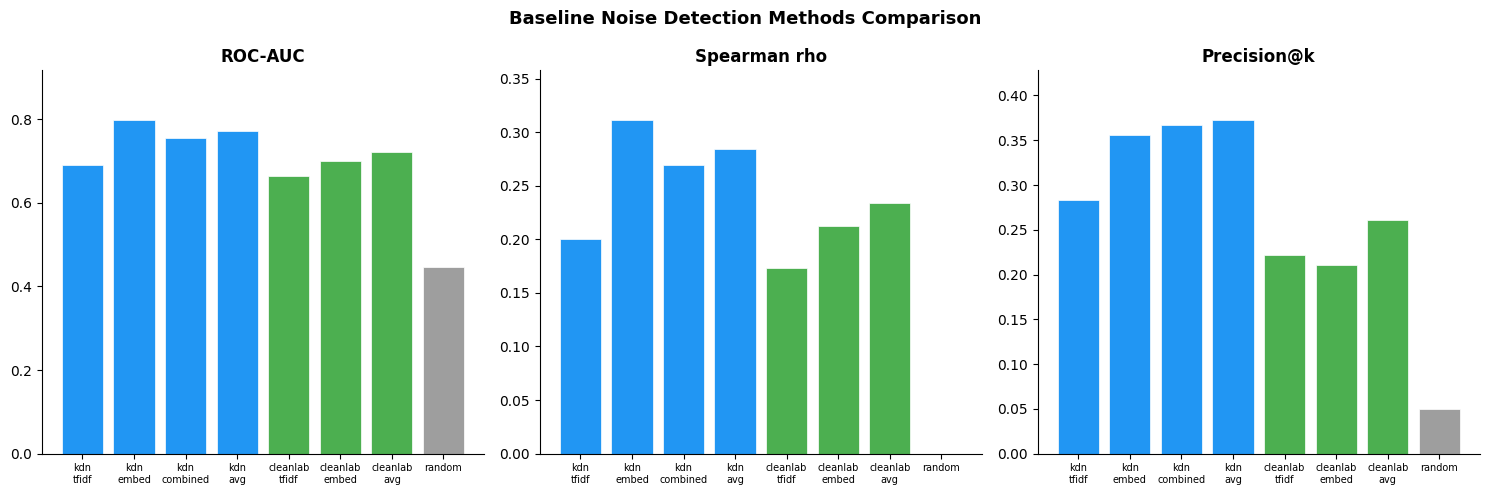

Figure saved to results_comparison.png


In [9]:
import re

# Collect per-trial metrics (exclude aggregates and knn_consist_* which duplicate kdn_*)
methods_to_plot = [
    "kdn_tfidf", "kdn_embed", "kdn_combined", "kdn_avg",
    "cleanlab_tfidf", "cleanlab_embed", "cleanlab_avg", "random"
]

all_metrics = {m: {"roc_auc": [], "spearman_rho": [], "precision_at_k": []} for m in methods_to_plot}

for ds_result in all_dataset_results:
    for ex in ds_result["examples"]:
        if ex.get("metadata_seed") == "aggregate":
            continue  # skip aggregate rows
        for method in methods_to_plot:
            key = f"predict_{method}"
            if key in ex:
                val = ex[key]
                # Parse "ROC-AUC=X.XXXX, rho=X.XXXX, P@k=X.XXXX"
                match = re.match(
                    r"ROC-AUC=([\d.]+|nan), rho=([-\d.]+|nan), P@k=([\d.]+|nan)", val
                )
                if match:
                    auc = float(match.group(1)) if match.group(1) != "nan" else float("nan")
                    rho = float(match.group(2)) if match.group(2) != "nan" else float("nan")
                    pak = float(match.group(3)) if match.group(3) != "nan" else float("nan")
                    all_metrics[method]["roc_auc"].append(auc)
                    all_metrics[method]["spearman_rho"].append(rho)
                    all_metrics[method]["precision_at_k"].append(pak)

# Print summary table
print(f"{'Method':<20} {'ROC-AUC':>10} {'Spearman rho':>14} {'Precision@k':>13}")
print("-" * 60)
for method in methods_to_plot:
    aucs = all_metrics[method]["roc_auc"]
    rhos = all_metrics[method]["spearman_rho"]
    paks = all_metrics[method]["precision_at_k"]
    if aucs:
        print(
            f"{method:<20} "
            f"{np.nanmean(aucs):>10.4f} "
            f"{np.nanmean(rhos):>14.4f} "
            f"{np.nanmean(paks):>13.4f}"
        )

# --- Grouped bar chart ---
metric_names = ["ROC-AUC", "Spearman rho", "Precision@k"]
metric_keys = ["roc_auc", "spearman_rho", "precision_at_k"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, metric_name, metric_key in zip(axes, metric_names, metric_keys):
    means = []
    labels = []
    colors = []
    color_map = {
        "kdn": "#2196F3", "cleanlab": "#4CAF50", "random": "#9E9E9E"
    }
    for method in methods_to_plot:
        vals = all_metrics[method][metric_key]
        if vals:
            means.append(np.nanmean(vals))
            labels.append(method.replace("_", "\n"))
            prefix = method.split("_")[0]
            colors.append(color_map.get(prefix, "#FF9800"))

    bars = ax.bar(range(len(means)), means, color=colors, edgecolor="white", linewidth=0.5)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=7, ha="center")
    ax.set_title(metric_name, fontweight="bold")
    ax.set_ylim(0, max(means) * 1.15 if means and max(means) > 0 else 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.suptitle("Baseline Noise Detection Methods Comparison", fontweight="bold", fontsize=13)
plt.tight_layout()
plt.savefig("results_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved to results_comparison.png")